In [1]:
# Importing packages
import os
import yaml
import logging
import pandas as pd
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.dada2.actions as dada2_actions
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.feature_table.visualizers import tabulate_seqs
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_table.visualizers import core_features

from qiime2.plugins.feature_table.methods import merge
from qiime2.plugins.feature_table.methods import merge_seqs
from qiime2.plugins.feature_table.methods import merge_taxa

from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Parameters
experiment_name = "thayane-PM-joined-trim"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-thayane"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/manifest.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/metadata.tsv"
class_col = "sample-id"
classifier_file = "/home/lauro/nupeb/rede-micro/models/silva-138-99-nb-classifier.qza"
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6

In [24]:
# Define paths
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
data_folder = '/home/lauro/nupeb/rede-micro/redemicro-thayane/data/'
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

input_path = {'single-end': {}, 'paired-end': {}}

for k in input_path.keys():
    input_path[k]['metadata'] = f"/home/lauro/nupeb/rede-micro/redemicro-thayane/data/{k}-metadata.tsv"
    if k == 'single-end':
        qiime_folder = os.path.join(base_dir, 'experiments', f'thayane-PM-joined-trim', 'qiime-artifacts')
        input_path[k]['tab'] = os.path.join(qiime_folder, f'dada2-{k}-tabs.qza')
        input_path[k]['seq'] = os.path.join(qiime_folder, f'dada2-{k}-reps.qza')
    else:
        qiime_folder = os.path.join(base_dir, 'experiments', f'thayane-PM-paired-end-trim-overlap-04', 'qiime-artifacts')
        input_path[k]['tab'] = os.path.join(qiime_folder, 'dada2-tabs.qza')
        input_path[k]['seq'] = os.path.join(qiime_folder, 'dada2-reps.qza')

print(input_path)

# # Original Single-End files
# se_metadata_path = "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/single-end-metadata.tsv"
# input_path['single-end']['tab'] = os.path.join(qiime_folder, 'dada2-tabs.qza')
# input_path['single-end']['seq'] = os.path.join(qiime_folder, 'dada2-reps.qza')
#
# # Original Paired-End files
# pe_metadata_path = "/home/lauro/nupeb/rede-micro/redemicro-thayane/data/paired-end-metadata.tsv"
# pe_path = '/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-single-end/'
# input_path['paired-end']['tab'] = os.path.join(pe_path, 'fezes_demux_paired_dada2_tabs.qza')
# input_path['paired-end']['seq'] = os.path.join(pe_path, 'fezes_demux_paired_dada2_reps.qza')

{'single-end': {'metadata': '/home/lauro/nupeb/rede-micro/redemicro-thayane/data/single-end-metadata.tsv', 'tab': '/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-joined-trim/qiime-artifacts/dada2-single-end-tabs.qza', 'seq': '/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-joined-trim/qiime-artifacts/dada2-single-end-reps.qza'}, 'paired-end': {'metadata': '/home/lauro/nupeb/rede-micro/redemicro-thayane/data/paired-end-metadata.tsv', 'tab': '/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-paired-end-trim-overlap-04/qiime-artifacts/dada2-tabs.qza', 'seq': '/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-paired-end-trim-overlap-04/qiime-artifacts/dada2-reps.qza'}}


In [25]:
# Load artifacts
se_metadata_artifact = Metadata.load(input_path['single-end']['metadata'])
pe_metadata_artifact = Metadata.load(input_path['paired-end']['metadata'])
print('number of samples in single-end metadata:', se_metadata_artifact.to_dataframe().shape)
print('number of samples in paired-end metadata:', pe_metadata_artifact.to_dataframe().shape)


input_artifact = {'single-end': {}, 'paired-end': {}}

# Original Single-End files
input_artifact['single-end']['tab'] = Artifact.load(input_path['single-end']['tab'])
input_artifact['single-end']['seq'] = Artifact.load(input_path['single-end']['seq'])

# Original Paired-End files
input_artifact['paired-end']['tab'] = Artifact.load(input_path['paired-end']['tab'])
input_artifact['paired-end']['seq'] = Artifact.load(input_path['paired-end']['seq'])

number of samples in single-end metadata: (6, 8)
number of samples in paired-end metadata: (38, 8)


In [26]:
all_ids = set(input_artifact['single-end']['tab'].view(pd.DataFrame).index)
all_ids |= set(input_artifact['paired-end']['tab'].view(pd.DataFrame).index)
print(f'lenght of all_ids: {len(all_ids)}')

lenght of all_ids: 44


## Filter exclusively Single-End samples

In [27]:
# Select metadata rows
se_to_keep = ['M01', 'M03', 'M06', 'M09', 'M12', 'M19']
se_metadata = se_metadata_artifact.filter_ids(ids_to_keep=se_to_keep)
se_metadata.to_dataframe().index

Index(['M01', 'M03', 'M06', 'M09', 'M12', 'M19'], dtype='object', name='sample-id')

In [28]:
# Create filtered table
se_filtered_table = filter_samples(
    table = input_artifact['single-end']['tab'],
    metadata = se_metadata,
).filtered_table
se_filtered_table.view(pd.DataFrame).shape

{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
6 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 1736 x 44 <class 'biom.table.Table'> with 2090 nonzero entries (2% dense)}
{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
6 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnPro

(6, 228)

In [29]:
# Filter sequences for selected samples
se_filtered_seqs = filter_seqs(
    data = input_artifact['single-end']['seq'],
    table = se_filtered_table,
).filtered_data
print(f'Number of sequences: {se_filtered_seqs.view(pd.Series).shape}')
print(f'{se_filtered_seqs.view(pd.Series).shape[0] / input_artifact["single-end"]["seq"].view(pd.Series).shape[0] * 100:.2f}% of sequences were kept')

{'metadata': None, 'where': None, 'exclude_ids': False, 'data': 00051a78b3e1ecd27314247dff25a208    (((G)), ((C)), ((C)), ((T)), ((A)), ((C)), ((G...
000f8bfd8a4b2441d868821eef660ecc    (((A)), ((C)), ((C)), ((T)), ((A)), ((C)), ((G...
0053504a75cbad644658d68e0d32aa7e    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
00d94a1863ec0f2c06c4ad049604e60e    (((G)), ((C)), ((C)), ((C)), ((T)), ((A)), ((C...
010045ee9c16bba62338fd5d55530b6a    (((G)), ((C)), ((C)), ((T)), ((A)), ((C)), ((G...
                                                          ...                        
ffc62661b58a6f59ad20e7ad34405896    (((T)), ((C)), ((C)), ((T)), ((A)), ((C)), ((G...
ffc9b5e055dca60dab5f464147875e3a    (((C)), ((G)), ((C)), ((C)), ((T)), ((A)), ((C...
ffca45f65366280127b61f681a7b9d7f    (((G)), ((C)), ((C)), ((T)), ((A)), ((C)), ((G...
ffcebd381e84cfe83cdacd5f6a6c25b4    (((G)), ((C)), ((G)), ((C)), ((G)), ((A)), ((A...
fff0ea2bfed7ded0d6e2d0b6db49329e    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)

## Filter post-menopause Paired-End sample

In [30]:

print(pe_metadata_artifact.to_dataframe().index)

Index(['M05', 'M33', 'M34', 'M35', 'M38', 'M39', 'M44', 'M46', 'M47', 'M52',
       'M55', 'M07', 'M64', 'M72', 'M73', 'M77', 'M78', 'M79', 'M88', 'M93',
       'M95', 'M99', 'M102', 'M107', 'M112', 'M120', 'M121', 'M126', 'M125',
       'M133', 'M134', 'M141', 'M144', 'M148', 'M150', 'M151', 'M155', 'M156'],
      dtype='object', name='sample-id')


In [31]:
# Select metadata rows
pe_to_keep = pe_metadata_artifact.to_dataframe().index
print(f'Number of samples: {len(pe_to_keep)}')
print(f'pe_to_keep: {pe_to_keep}')
pe_metadata = pe_metadata_artifact.filter_ids(ids_to_keep=pe_to_keep)
pe_metadata.to_dataframe().shape

Number of samples: 38
pe_to_keep: Index(['M05', 'M33', 'M34', 'M35', 'M38', 'M39', 'M44', 'M46', 'M47', 'M52',
       'M55', 'M07', 'M64', 'M72', 'M73', 'M77', 'M78', 'M79', 'M88', 'M93',
       'M95', 'M99', 'M102', 'M107', 'M112', 'M120', 'M121', 'M126', 'M125',
       'M133', 'M134', 'M141', 'M144', 'M148', 'M150', 'M151', 'M155', 'M156'],
      dtype='object', name='sample-id')


(38, 8)

In [32]:
# Filter feature table for selected samples
pe_filtered_table = filter_samples(
    table = input_artifact['paired-end']['tab'],
    metadata = pe_metadata,
).filtered_table
pe_filtered_table.view(pd.DataFrame).shape
# pe_filtered_table.view(pd.DataFrame).columns

{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
38 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'where': None, 'exclude_ids': False, 'filter_empty_features': True, 'table': 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)}
{'min_frequency': 0, 'max_frequency': None, 'min_features': 0, 'max_features': None, 'metadata': Metadata
--------
38 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnP

(38, 2210)

In [33]:
# Filter sequences for selected samples
pe_filtered_seqs = filter_seqs(
    data = input_artifact['paired-end']['seq'],
    table = pe_filtered_table,
).filtered_data
pe_filtered_seqs.view(pd.Series).shape

{'metadata': None, 'where': None, 'exclude_ids': False, 'data': ec39293a8db6cdfc99fecc1decfa59d7    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
f7a1c2a7dc74eb24446faaa79f519ee6    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
fd204f7a88e546b2288fb9b86489ba32    (((T)), ((G)), ((A)), ((G)), ((G)), ((A)), ((A...
ddbf23c8c5653d14479d9bf997ef7e1b    (((T)), ((G)), ((A)), ((G)), ((G)), ((A)), ((A...
2e9f1c3013022ced2c0c9567d59fc064    (((T)), ((G)), ((G)), ((G)), ((G)), ((G)), ((A...
                                                          ...                        
0d7e4a5afc9198a77975163fef8762bf    (((A)), ((A)), ((A)), ((T)), ((C)), ((T)), ((T...
42775e607d1331feeed46556a21008af    (((A)), ((A)), ((A)), ((T)), ((C)), ((T)), ((T...
dae7ea67a9476f6f7215b45b4afbb130    (((A)), ((A)), ((T)), ((A)), ((A)), ((A)), ((A...
4dc5a0950c566176a78fdf0fd19b2dc9    (((T)), ((T)), ((A)), ((G)), ((G)), ((A)), ((A...
961fde1c25c0da71e2b45ef4cf5c5188    (((T)), ((T)), ((T)), ((A)), ((A)), ((T)

(2210,)

## Merging Single-End and Paired-End tables

In [34]:
# Merge feature tables
merged_feature_table = merge(
    tables = [se_filtered_table, pe_filtered_table],
).merged_table
merged_feature_table.view(pd.DataFrame).shape

{'overlap_method': 'error_on_overlapping_sample', 'tables': [228 x 6 <class 'biom.table.Table'> with 321 nonzero entries (23% dense), 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)]}
{'overlap_method': 'error_on_overlapping_sample', 'tables': [228 x 6 <class 'biom.table.Table'> with 321 nonzero entries (23% dense), 2210 x 38 <class 'biom.table.Table'> with 6010 nonzero entries (7% dense)]}


(44, 2403)

In [35]:
# Merge sequences
merged_sequences = merge_seqs(
    data = [se_filtered_seqs, pe_filtered_seqs]
).merged_data
merged_sequences.view(pd.Series).shape

{'data': [0053504a75cbad644658d68e0d32aa7e    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
024d64ec6ca834ca7a0889e9b43cce4b    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
0260fb0fc51b3a1bfaa4672627095949    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
0469e2beaf339563f954212ae6813c0c    (((T)), ((G)), ((A)), ((G)), ((G)), ((A)), ((A...
04b25905ce00d0d22ca493f890e5bb1d    (((T)), ((G)), ((G)), ((G)), ((G)), ((G)), ((A...
                                                          ...                        
fd725ca2a934257e02b106b0a660f7f3    (((T)), ((G)), ((A)), ((G)), ((G)), ((G)), ((A...
fdb7d9ffd28af0bdf79a5704b703377b    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
ffa2d3d4e030a8f45850c379c0d196f5    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
ffcebd381e84cfe83cdacd5f6a6c25b4    (((G)), ((C)), ((G)), ((C)), ((G)), ((A)), ((A...
fff0ea2bfed7ded0d6e2d0b6db49329e    (((T)), ((G)), ((G)), ((G)), ((G)), ((A)), ((A...
Length: 228, dtype: object, ec39293a8db6cdfc

(2403,)

In [36]:
df = merged_feature_table.view(pd.DataFrame)
new_idx = [i.split('-')[1] if i.startswith('I') else i for i in df.index]
df.index = new_idx
merged_feature_table = Artifact.import_data("FeatureTable[Frequency]", df)

## Merging Single-End and Paired-End metadata

In [37]:
# Get metadata rows
se_metadata = se_metadata_artifact.to_dataframe()
pe_metadata = pe_metadata_artifact.to_dataframe()
# Merge two dataframes by rows
metadata_df = pd.concat([se_metadata, pe_metadata])
# Convert metadtata to qiime2 artifact
metadata_qa = Metadata(metadata_df)
metadata_path = os.path.join(data_folder, 'merged-trim-metadata.tsv')
metadata_qa.save(metadata_path)

'/home/lauro/nupeb/rede-micro/redemicro-thayane/data/merged-trim-metadata.tsv'

In [38]:
new_tab_path = '/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-joined-trim/qiime-artifacts/dada2-tabs.qza'
new_seq_path = '/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-joined-trim/qiime-artifacts/dada2-reps.qza'

## Persist merged data

In [39]:
# TODO: save merged data into a new location

# Replace table and sequences
merged_feature_table.save(new_tab_path)
merged_sequences.save(new_seq_path)

'/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-joined-trim/qiime-artifacts/dada2-reps.qza'

In [40]:
# Create view and save frequency table
tabs_view = summarize(table=merged_feature_table, sample_metadata=metadata_qa).visualization
tabs_view.save(new_tab_path[:-1] + 'v')

{'sample_metadata': Metadata
--------
44 IDs x 8 columns
class-straw:        ColumnProperties(type='categorical')
local-coleta:       ColumnProperties(type='categorical')
idade:              ColumnProperties(type='numeric')
idade-menarca:      ColumnProperties(type='numeric')
tempo-menopausa:    ColumnProperties(type='numeric')
above_10:           ColumnProperties(type='categorical')
menopausa-age-qcut: ColumnProperties(type='categorical')
menopausa-age-bins: ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation., 'table': 2403 x 44 <class 'biom.table.Table'> with 6331 nonzero entries (5% dense)}


'/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-joined-trim/qiime-artifacts/dada2-tabs.qzv'

In [41]:
# Create view and save representative sequences
reps_view = tabulate_seqs(data=merged_sequences).visualization
reps_view.save(new_seq_path[:-1] + 'v')

{'data': <q2_types.feature_data._transformer.DNAIterator object at 0x7f7907d83af0>}


'/home/lauro/nupeb/rede-micro/redemicro-thayane/experiments/thayane-PM-joined-trim/qiime-artifacts/dada2-reps.qzv'

In [150]:
merged_tab_df = merged_feature_table.view(pd.DataFrame).astype(int)
freqs = merged_tab_df.sum(axis=0)
ocorr = merged_tab_df.apply(lambda x : sum(x > 0))
abundance_diversity_df = pd.concat([freqs, ocorr], axis=1)

Text(0.5, 0, 'log10(Abundance)')

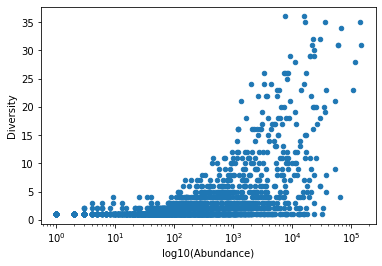

In [160]:
abundance_diversity_df.plot.scatter(x=0, y=1, logx=True)
plt.ylabel('Diversity')
plt.xlabel('log10(Abundance)')